# Analysis of output files
## Prepare environment, functions etc.

In [1]:
import os
import sys
import pandas
import matplotlib
import numpy
from algorithm_tester.helpers import FilePair
import matplotlib.pyplot as plt


# Zapnout zobrazování grafů (procento uvozuje „magickou” zkratku IPythonu):
%matplotlib inline

path = 'tester_results'
evo_path = f'tester_results_evo'
sol_path = '../data'

sol_cols = ["output_filename", "best_value"]
evo_cols = ["output_filename", "num_of_satisfied_clauses", "weight"]

In [2]:
#pandas.set_option('display.max_rows', None)
#pandas.read_csv?

## Important functions

In [3]:
def get_file_paths_from_dir(path: str, include_sol: bool = False, include_instance: bool = True) -> (str, str, str):
    dataset_prefix: str = path.split("/")[-1]
    for root, _, files in os.walk(path):
        dataset: str = dataset_prefix + "_" + "_".join(root.replace(path, "")[1:].split('/'))
        for file in files:
            if "column" not in file and ".dat" in file:
                if ("_sol" in file and include_sol) or ("_inst" in file and include_instance):
                    yield (dataset, root, file)

def get_cols_list(path: str):
    cols = pandas.read_csv(path, index_col=None, delimiter=" ", header=None)
    return list(cols.iloc[0])

def create_avg_time_table(table, name: str, column_name: str = "item_count"):
    # Create a table of average times according to algorithm and item_count columns
    avg_times = table.groupby(["algorithm_name", column_name])['elapsed_time'] \
        .mean().reset_index()
    avg_times = avg_times.round(2)
    
    avg_configs = table.groupby(["algorithm_name", column_name])['elapsed_configs']\
        .mean().reset_index()
    
    avg_times = avg_times.merge(avg_configs, on=["algorithm_name", column_name])

    # Move all values of algorithm column into separate columns
    #avg_times = avg_times.unstack("algorithm_name")
    #avg_times.columns = avg_times.columns.droplevel()
    avg_times.name = f"Avg #configs per {column_name}"
    avg_times.sort_values(by=column_name, inplace=True)
    #avg_times.fillna("-", inplace=True)

    # Save the dataframe to csv
    #avg_times.to_excel(f'excel/{name}_avg_times.xlsx', sheet_name=name)
    
    return avg_times

def create_avg_error_table(table, column_name: str, table_name: str = "unknown"):
    table["relative_error"] = numpy.abs(table["best_value"] - table["found_value"])/table["best_value"]
    table = table.fillna(0)
    
    error_group = table.groupby([column_name, "algorithm_name"])["relative_error"]

    error_max = error_group.max().reset_index() \
        .rename(columns={'relative_error':'max_relative_error'})
    error_avg = error_group.mean().reset_index() \
        .rename(columns={'relative_error':'avg_relative_error'})
    
    # Construct, unstack
    avg_error = pandas.merge(error_max, error_avg, on=[column_name, "algorithm_name"])
    #avg_error = avg_error.set_index(["algorithm_name", column_name]).unstack("algorithm_name")
    #avg_error = error_max.join(error_avg).round(6)
    #avg_error.columns = ["max_relative_error", "avg_relative_error"]
    avg_error.name = f"Avg & max relative error per {column_name}"
    
    
    avg_error.set_index(["algorithm_name", column_name]).unstack("algorithm_name")\
        .round(6)\
        .to_excel(f"excel/{table_name}_avg_error.xlsx", sheet_name=table_name)
    
    return avg_error

def save_plot(table, title: str, column_name: str, output_name: str, y_label: str = "Relative errors"):
    worktable = table.loc[:, column_name].copy()
    
    plot = worktable.plot()
    plot.set_ylabel(y_label)

    figure = plot.get_figure()
    figure.suptitle(title)
    figure.savefig(f"excel/{output_name}.pdf")
    
    return plot

def save_table(table, output_name):
    table.round(6).to_excel(f"excel/{output_name}_table.xlsx", sheet_name=output_name)

In [13]:
def init_evo_plot(title: str, ylabel: str = "Satisfied clauses", figsize = [13,3]):
    fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=figsize)
    axes.set_xlabel('step')
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    
    return fig, axes

def get_evo_table(path: str, column: str = "num_of_satisfied_clauses"):
    evo_table = pandas.read_csv(path, index_col=None, delimiter=" ", header=None)
    evo_table.columns = evo_cols
    evo_table["step"] = range(evo_table[column].count())
    return evo_table
    
def add_evo_plot(path: str, yaxis_label: str, axes, column: str = "num_of_satisfied_clauses"):
    evo_table = get_evo_table(path)
    
    data = evo_table.sort_values(by="step").set_index(["step"]).loc[:, column]
    
    ax = axes.plot(data, label=f'{yaxis_label}')
    return evo_table

def get_full_table_for_dataset(instance_path: str, sol_path: str, instance_cols, sol_cols):
    output_table = None
    
    # Get all solutions from all files
    output_table = pandas.read_csv(instance_path, index_col=None, delimiter=" ", header=None)\
        .iloc[:, [0, 1,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]]
    output_table.columns = instance_cols

    # Add data from solution file
    sols_table = pandas.read_csv(sol_path, index_col=None, delimiter=" ", header=None)\
        .iloc[:, [0, 1]]
    sols_table.columns = sol_cols
    sols_table.drop_duplicates(subset="output_filename", inplace=True)
        
    output_table = pandas.merge(sols_table, output_table, on=["output_filename"], how="outer")
    output_table = output_table.astype({'found_value': 'int64'})
    output_table["relative_mistake_weights"] = numpy.abs(output_table["best_value"] - output_table["found_value"])/output_table["best_value"]

    output_table["relative_mistake_clauses"] = (output_table["num_of_clauses"] - output_table["num_of_satisfied_clauses"])/output_table["num_of_satisfied_clauses"]
    output_table["has_best_value"] = ~numpy.isnan(output_table["best_value"])
    
    output_table = output_table.fillna(0.0).astype({'best_value': 'int64'})
    
    return output_table

def get_all_tables_of_results(base: str):
    cols = get_cols_list("column_description.dat")
    cols.remove("vars_output")
    dfs = list()
    
    datasets = [
        "wuf-A/wuf20-88-A",
        "wuf-A/wuf20-91-A",
        
        "wuf-M/wuf20-78-M",
        "wuf-M/wuf50-201-M",
        
        "wuf-N/wuf20-78-N",
        "wuf-N/wuf50-201-N",
        
        "wuf-Q/wuf20-78-Q",
        "wuf-Q/wuf50-201-Q",
        
        "wuf-R/wuf20-78-R",
        "wuf-R/wuf50-201-R"
    ]
    for algorithm in ["SA_SAT_V1", "SA_SAT_V2", "SA_SAT_V3"]:
        
        for dataset in datasets:
            d = get_full_table_for_dataset(f'{base}/{dataset}_{algorithm}.dat', f'{sol_path}/{dataset}-opt.dat', cols, sol_cols)
            dfs.append(d)
    
    return pandas.concat(dfs)

# Load all tables

In [5]:
v1_simple = get_all_tables_of_results("tester_results_V1_Simple")
v2_moreCooling = get_all_tables_of_results("tester_results_V2_MoreCooling")
v3_higherTemp = get_all_tables_of_results("tester_results_V3_HigherTemp")
v4_moreCycles = get_all_tables_of_results("tester_results_V4_MoreCycles")

v1_simple

,output_filename,best_value,found_value,num_of_vars,num_of_clauses,algorithm_name,init_temperature,min_temperature,cooling,cycles,is_valid,num_of_satisfied_clauses,retry_count,elapsed_configs,elapsed_time,relative_mistake_weights,relative_mistake_clauses,has_best_value
0,uf20-01000,73,62,20,88,SA_SAT_V1,1000.0,0.5,0.95,50,True,88,1,7450,167.615349,0.150685,0.0,True
1,uf20-0102,67,27,20,88,SA_SAT_V1,1000.0,0.5,0.95,50,True,88,1,7450,170.020503,0.597015,0.0,True
2,uf20-0107,80,64,20,88,SA_SAT_V1,1000.0,0.5,0.95,50,True,88,1,7450,183.717161,0.200000,0.0,True
3,uf20-0108,75,69,20,88,SA_SAT_V1,1000.0,0.5,0.95,50,True,88,1,7450,167.083992,0.080000,0.0,True
4,uf20-0110,69,50,20,88,SA_SAT_V1,1000.0,0.5,0.95,50,True,88,1,7450,176.824338,0.275362,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,uf50-0183,0,78338,50,201,SA_SAT_V3,1000.0,0.5,0.95,50,True,201,1,7450,659.820561,0.000000,0.0,False
996,uf50-0797,0,80823,50,201,SA_SAT_V3,1000.0,0.5,0.95,50,True,201,1,7450,656.530549,0.000000,0.0,False
997,uf50-0972,0,87961,50,201,SA_SAT_V3,1000.0,0.5,0.95,50,True,201,1,7450,867.745220,0.000000,0.0,False
998,uf50-0579,0,43601,50,201,SA_SAT_V3,1000.0,0.5,0.95,50,True,201,1,7450,619.599488,0.000000,0.0,False


In [6]:
def create_avg_error_table_by_best_value(table, column_name: str, table_name: str = "unknown"):
    t = table.query("has_best_value == True").copy()
    t = t.fillna(0)
    
    error_group = table.groupby([column_name, "algorithm_name"])["relative_mistake_weights"]

    error_max = error_group.max().reset_index() \
        .rename(columns={'relative_mistake_weights':'max_relative_error'})
    error_avg = error_group.mean().reset_index() \
        .rename(columns={'relative_mistake_weights':'avg_relative_error'})
    
    # Construct, unstack
    avg_error = pandas.merge(error_max, error_avg, on=[column_name, "algorithm_name"])
    #avg_error = avg_error.set_index(["algorithm_name", column_name]).unstack("algorithm_name")
    #avg_error = error_max.join(error_avg).round(6)
    #avg_error.columns = ["max_relative_error", "avg_relative_error"]
    avg_error.name = f"Avg & max relative error per {column_name}"
    avg_error = avg_error.set_index(["algorithm_name", column_name]).unstack("algorithm_name")
    
    
    #avg_error.round(6).to_excel(f"excel/{table_name}_avg_error.xlsx", sheet_name=table_name)
    
    return avg_error

create_avg_error_table_by_best_value(v1_simple, "num_of_clauses")


max_relative_error                     avg_relative_error  \
algorithm_name          SA_SAT_V1 SA_SAT_V2 SA_SAT_V3          SA_SAT_V1   
num_of_clauses                                                             
78                       0.560033  0.627398  0.739039           0.062906   
88                       0.651515  0.631579  0.636364           0.217313   
91                       0.798319  0.780822  0.791045           0.176998   
201                      0.729612  0.680659  0.523274           0.009053   

                                    
algorithm_name SA_SAT_V2 SA_SAT_V3  
num_of_clauses                      
78              0.062849  0.058021  
88              0.211970  0.199787  
91              0.128109  0.109993  
201             0.006231  0.004341

# Evo files

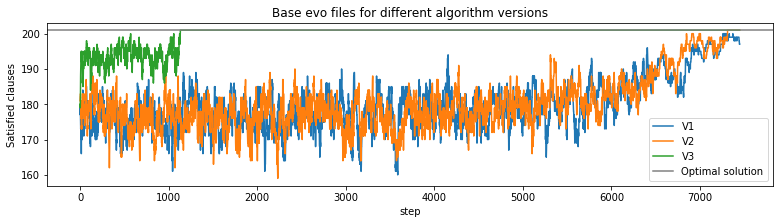

In [25]:
num_of_clauses = 201
optimal_solution = 13570

fig, axes = init_evo_plot("Base evo files for different algorithm versions")

add_evo_plot(f"{evo_path}/simple/wuf50-0987_SA_SAT_V1_sol.evo", "V1", axes)
add_evo_plot(f"{evo_path}/simple/wuf50-0987_SA_SAT_V2_sol.evo", "V2", axes)
add_evo_plot(f"{evo_path}/simple/wuf50-0987_SA_SAT_V3_sol.evo", "V3", axes)
axes.axhline(y=num_of_clauses, color="grey", label="Optimal solution")
axes.legend()

fig, axes = init_evo_plot("Base evo files for different algorithm versions")

add_evo_plot(f"{evo_path}/simple/wuf50-0987_SA_SAT_V1_sol.evo", "V1", axes)
add_evo_plot(f"{evo_path}/simple/wuf50-0987_SA_SAT_V2_sol.evo", "V2", axes)
add_evo_plot(f"{evo_path}/simple/wuf50-0987_SA_SAT_V3_sol.evo", "V3", axes)
axes.axhline(y=optimal_solution, color="grey", label="Optimal solution")
axes.legend()

In [ ]:
full_table = nk_table.append(zkc_table).append(zkw_table).query("algorithm_name != 'SA_OLD'")
sapenalty_error_comp = create_avg_error_table(full_table, "item_count", "sapenalty_comp")\
    .set_index(["item_count", "algorithm_name"]).unstack("algorithm_name")\
    .drop(columns="max_relative_error")

sapenalty_comp_plot = sapenalty_error_comp.plot.bar(legend=True)
sapenalty_comp_plot.set_ylabel("Relative errors")

figure = sapenalty_comp_plot.get_figure()
figure.suptitle("SA/SAPenalty relative error comparison")
figure.savefig("excel/sapenalty_comp.pdf")

sapenalty_comp_plot

### Initial temperature

In [ ]:
print(error_init_temp)

out = pandas.merge(error_init_temp, time_init_temp, on=["algorithm_name", "init_temp"])
save_table(out, "init_temp_errors_speed")
save_plot(error_init_temp, "Avg error - init temperatures", "avg_relative_error", "init_temp_avg_error")


In [ ]:
print(time_init_temp)

save_plot(time_init_temp, "Avg speed - init temperatures", "elapsed_time", "init_temp_time_ms", "Time[ms]")


In [ ]:
save_plot(time_init_temp, "Avg speed - init temperatures", "elapsed_configs", "init_temp_time_configs", "Time[configs]")


In [ ]:
fig, axes = init_evo_plot("Evolution of costs for different init temperatures")

add_evo_plot(f"{evo_path}/InitTemperature/EvoFile_40_inst_SA_1500.evo", evo_cols, "1500", axes)
add_evo_plot(f"{evo_path}/InitTemperature/EvoFile_40_inst_SA_2500.evo", evo_cols, "2500", axes)
axes.legend()

fig.savefig(f"excel/init_temp_evo.pdf")